In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [29]:
data_dir = 'Sign_Language_digits'
#C:/Users/Arnab/Downloads/Sign-language-digits-dataset/
def load_split_train_test(datadir, valid_size = .2):
    
    train_transforms = transforms.Compose([transforms.Resize(100),transforms.ToTensor(),])
    test_transforms = transforms.Compose([transforms.Resize(100),transforms.ToTensor(),])
    train_data = datasets.ImageFolder(datadir,transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    from torch.utils.data.sampler import SubsetRandomSampler
    
    train_idx, test_idx = indices[split:], indices[:split]
    print(len(train_idx), len(test_idx))
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .25)
print(trainloader.dataset.classes)

1547 515
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)


In [6]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(1024*2, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device);
#noshow

In [7]:
epochs = 8
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
                
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/8.. Train loss: 3.399.. Test loss: 2.549.. Test accuracy: 0.358
Epoch 1/8.. Train loss: 1.804.. Test loss: 1.786.. Test accuracy: 0.426
Epoch 2/8.. Train loss: 1.302.. Test loss: 1.294.. Test accuracy: 0.584
Epoch 2/8.. Train loss: 0.968.. Test loss: 0.953.. Test accuracy: 0.683
Epoch 2/8.. Train loss: 0.829.. Test loss: 1.015.. Test accuracy: 0.615
Epoch 3/8.. Train loss: 0.774.. Test loss: 0.820.. Test accuracy: 0.701
Epoch 3/8.. Train loss: 0.783.. Test loss: 0.801.. Test accuracy: 0.699
Epoch 4/8.. Train loss: 0.730.. Test loss: 0.644.. Test accuracy: 0.783
Epoch 4/8.. Train loss: 0.600.. Test loss: 0.701.. Test accuracy: 0.729
Epoch 4/8.. Train loss: 0.791.. Test loss: 0.844.. Test accuracy: 0.678
Epoch 5/8.. Train loss: 0.574.. Test loss: 0.759.. Test accuracy: 0.741
Epoch 5/8.. Train loss: 0.526.. Test loss: 0.719.. Test accuracy: 0.730
Epoch 6/8.. Train loss: 0.521.. Test loss: 0.597.. Test accuracy: 0.781
Epoch 6/8.. Train loss: 0.512.. Test loss: 0.782.. Test accuracy

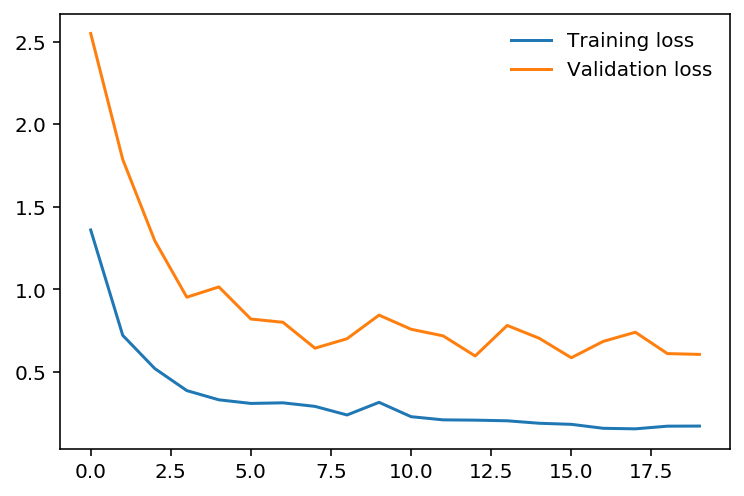

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [9]:
torch.save(model, 'Hand_sign_model.pth')
test_transforms = transforms.Compose([transforms.Resize(100),
                                      transforms.ToTensor()])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('Hand_sign_model.pth')
model.eval();

In [11]:
from torch.autograd import Variable

In [12]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [13]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return (images,labels,classes)

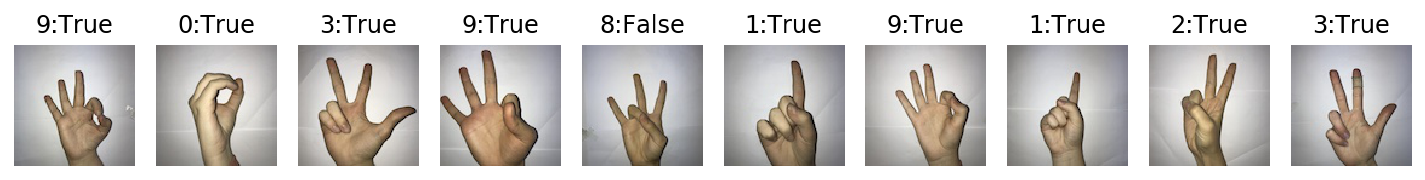

In [14]:
to_pil = transforms.ToPILImage()
images,labels,classes= get_random_images(10)
fig=plt.figure(figsize=(10,10))

for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout()   
plt.show()

In [48]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

images,labels,classes= get_random_images(515)
y_pred=[]
y_true=[]
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    y_pred.append(index)
    y_true.append(labels[ii])


In [51]:
for ii in range(len(images)):
    y_true[ii]=y_true[ii].tolist()


In [61]:
print('The f1 scores are:\n',f1_score(y_true,y_pred,average=None),'\n') #f1_score of each class
print('The confusion_matrix is:\n',confusion_matrix(y_true,y_pred))

The f1 scores are:
 [0.98924731 0.89719626 0.84375    0.92156863 0.91489362 0.98
 0.81632653 0.6875     0.69491525 0.89361702] 

The confusion_matrix is:
 [[46  1  0  0  0  0  0  0  0  0]
 [ 0 48  1  0  0  0  0  0  1  0]
 [ 0  5 54  1  0  0  1  1  0  0]
 [ 0  0  0 47  0  0  0  0  4  2]
 [ 0  0  1  0 43  1  4  0  0  0]
 [ 0  0  0  1  0 49  0  0  0  0]
 [ 0  1  6  0  1  0 40  0  1  0]
 [ 0  0  2  0  1  0  4 33 19  1]
 [ 0  1  2  0  0  0  0  2 41  3]
 [ 0  1  0  0  0  0  0  0  3 42]]
